In [1]:
# magics: ensures that any changes to the modules loaded below will be re-loaded automatically
%load_ext autoreload
%autoreload 2

# load general packages
import numpy as np
import matplotlib.pyplot as plt

# load general packages
import numpy as np

# load modules related to this exercise
from model_zucher import zurcher
from Solve_NFXP import solve_NFXP
import estimate_NFXP as estimate
import warnings
# Turn off warnings: We turn of warnings as a result of overflow. This occurs as the optimizer will sometimes guess on non-feasible transition probabilities. 
warnings.filterwarnings("ignore", category=RuntimeWarning)


#  Exercise 3: Demand function

#### 1. Find the equilibrium distirbution of mileage

In [9]:
# Setup
do_settings = {
    'n': 90
}

model = zurcher(**do_settings)
solver = solve_NFXP()

#Read the data
data = model.read_busdata(bustypes=[1,2,3,4])
samplesize = data.shape[0]
uncond_R_P = sum(data.d)/samplesize

# Estimate
nfxp_model, optim_res, pnames, theta_hat, Avar, converged=estimate.estimate(model, solver,data)


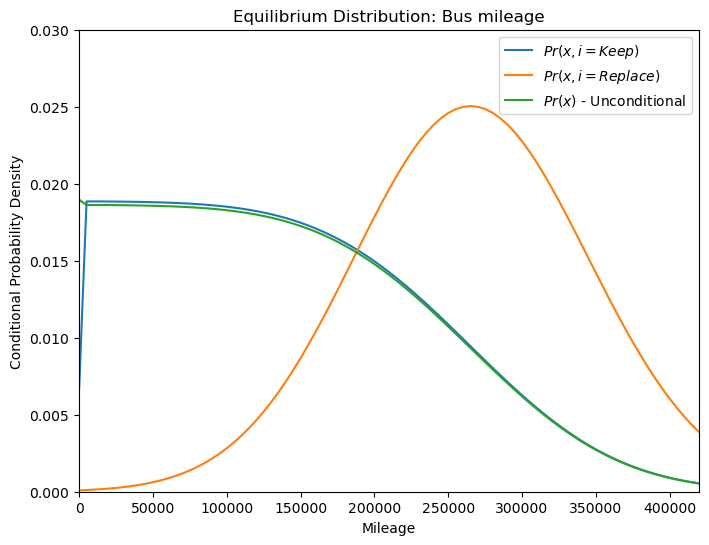

In [3]:
# Update the values with the estimated parameters
do_settings = {
    'n': 90,
    'RC': theta_hat[0],
    'c': theta_hat[1],
    'p': np.array(theta_hat[2:])
}
ev0 = np.zeros((model.n))
model_est = zurcher(**do_settings)
ev,pk = solver.poly(model_est.bellman,ev0, beta = model_est.beta, output=2)

# Find the probability functions
pp, pp_K, pp_R = model_est.eqb(pk)

fig = plt.figure(figsize=(8,6)) 
ax = fig.add_subplot(1,1,1)

ax.plot(model_est.grid*(model_est.max*1000)/model_est.n,pp_K/sum(pp_K))
ax.plot(model_est.grid*(model_est.max*1000)/model_est.n,pp_R/sum(pp_R))
ax.plot(model_est.grid*(model_est.max*1000)/model_est.n,pp/sum(pp))


ax.set_title(f'Equilibrium Distribution: Bus mileage')
ax.set_xlabel("Mileage")
ax.set_ylabel("Conditional Probability Density")
ax.set_xlim(0, 420000)
ax.set_ylim(0, 0.03)

plt.legend((f'$Pr(x, i=Keep)$',f'$Pr(x, i=Replace)$', f'$Pr(x)$ - Unconditional'))

plt.show()

- The probability of replacement (orange) peaks at higher mileage levels.
- The unconditional density (green) is highest in the middle range, indicating that buses accumulate mileage before replacement
- The two conditional distributions illustrate the balance between running costs and replacement incentives.

#### 2. Find the scale of the cost function
a) How does the scale of the cost function relate to the estimate of RC and c? Hint: We implicitly assume that the standard deviation of the extreme value type 1 distributed shocks are equal to 1. 
- The model uses a nomalized scale, where the extreme value type-1 distributed shocks have a standard deviation of 1. The estimated values of $\textit{RC}$ and $\textit{c}$ are in this scale. In order to convert them into real cost terms, they must be scaled by a scaling factor

b) What is the actual average replacement cost? Hint: Use the stuctural estimates and tabel III in  Rust (1987), "Optimal Replacement of GMC Bus Engines: An Emperical Model of Harold Zurcher (Table 3, Bus group 1,2,3,4)
- The estiamted $\textit{RC}$ is $11,76$ and the actual cost average replacement cost is $86.200$ dollars. Therefore, we may calculate
$$scale=\frac{8062}{RC_{est}}=\frac{8062}{9.76}=826.39$$ 

c) How can we use this to estimate the scale of the cost function? Calculate the scale.

In [7]:
RC = 8062
RC_scale = model_est.RC 
scale = RC/RC_scale

print(f'The scale for bustype 1-4 is: {scale:.2f}')

The scale for bustype 1-4 is: 826.39


#### 3. Find the implied Demand function

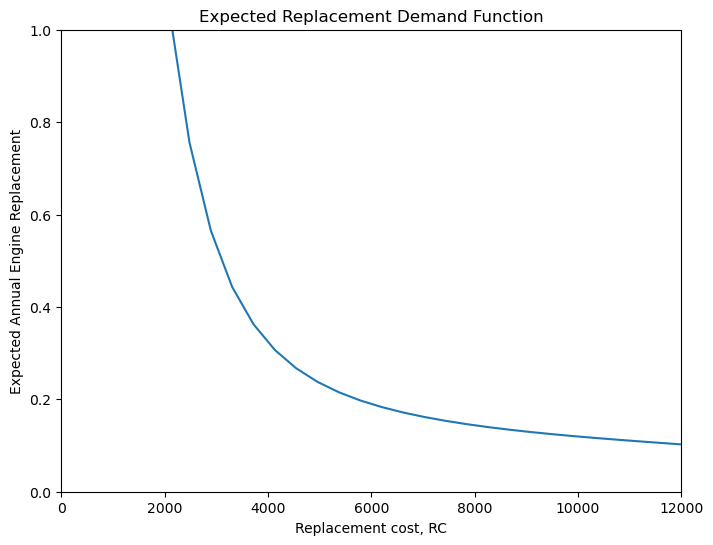

In [10]:
# Expected Demand, as a function of Replacement cost
import copy
mp0 = copy.copy(model_est.RC)
NRC = 59
RCgrid = np.linspace(1,30,NRC)
ev0 = np.zeros((model.n))

Demand = np.empty(NRC)

for i,val in enumerate(RCgrid):
    do_settings = {
    'n': 90,
    'RC': val,
    'c': theta_hat[1],
    'p': np.array(theta_hat[2:])
    }

    model = zurcher(**do_settings)
    _,pk = solver.poly(model.bellman, ev0, beta= model.beta, output=2)
    
    # Find the probability functions
    pp, pp_K, pp_R = model.eqb(pk)
    
    Demand[i] = 12*sum(pp_R)

fig = plt.figure(figsize=(8,6)) 
ax2 = fig.add_subplot(1,1,1)
ax2.plot(RCgrid*scale,Demand)
ax2.set_title(f'Expected Replacement Demand Function')
ax2.set_xlabel("Replacement cost, RC")
ax2.set_ylabel("Expected Annual Engine Replacement")
ax2.set_xlim(0,12000)
ax2.set_ylim(0,1)

plt.show()

- Higher replacement costs → Lower probability of replacement and vice versa. This behavior aligns with economic intuition and confirms the model’s validity.


#### 4. Try estimate the demand function for different values of $\beta$. Does the change in the demand function makes intuitively sense?

a) Where do the demand curves cross?

In [16]:
beta_vec = np.array([0.0001, 0.9999])

Demand_beta = np.empty((NRC,2))
scale_beta = np.empty(2)


for j,beta in enumerate(beta_vec):
    # Setup
    do_settings = {
        'n': 90,
        'beta': beta
    }

    model = zurcher(**do_settings)
    solver = solve_NFXP()

    # Estimate
    _, _, _, theta_hat,_, _=estimate.estimate(model, solver,data)
    
    #scale_beta[j] = RC/copy.copy(model_est.RC)
    scale_beta[j] = RC/copy.copy(theta_hat[0])
    
    for i,val in enumerate(RCgrid):
        do_settings = {
            'n': 90,
            'beta': beta,
            'RC': val,
            'c': theta_hat[1],
            'p': np.array(theta_hat[2:])
        }
        ev0 = np.zeros((model.n))
        model = zurcher(**do_settings)
        _,pk = solver.poly(model.bellman,ev0, beta=model.beta, output=2)

        # Find the probability functions
        pp, pp_K, pp_R = model.eqb(pk)
    

        Demand_beta[i,j] = 12*sum(pp_R)


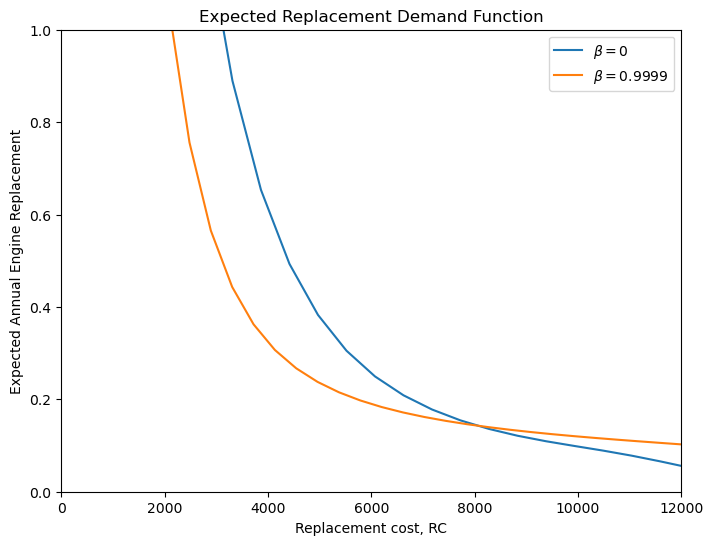

In [17]:
fig = plt.figure(figsize=(8,6)) 
ax2 = fig.add_subplot(1,1,1)
ax2.plot(RCgrid*scale_beta[0],Demand_beta[:,0])
ax2.plot(RCgrid*scale_beta[1],Demand_beta[:,1])
plt.legend((f'$\u03B2=0$',f'$\u03B2= 0.9999$'))
ax2.set_title(f'Expected Replacement Demand Function')
ax2.set_xlabel("Replacement cost, RC")
ax2.set_ylabel("Expected Annual Engine Replacement")
ax2.set_xlim(0,12000)
ax2.set_ylim(0,1)

plt.show()

- The demand function is recalculated for different values of $\beta$. The resulting demand curves are then compared
- Lower $\beta$, i.e. more impatient firm replace earlier at lower milage, while more higher $\beta$(more patient) hold onto the buses longer. 
- The orange line lies below the blue, mean that the more patient firms defer placement. This is because a firm with higher discount factor, (more patient), palces more weight on future costs, so it delays replacement. While a more impatient firm want to avoid future repair costs by replacing sooner. 

#### 5. What are the advantage and disadvantage of using a structual model to estimate the demand?

Unlike reduced-form approaches, they model decision-making processes explicitly, allowing for deeper insights into firm behavior. They are particularly useful for evaluating policy interventions, such as subsidies, by predicting how firms would respond to changes in economic conditions. Additionally, these models estimate fundamental economic parameters, providing interpretable results beyond simple correlations.

However, structural models come with challenges. They are computationally intensive, requiring the solution of Bellman equations and the use of Nested Fixed Point (NFXP) algorithms, making them significantly slower than reduced-form methods. They also rely on strong parametric assumptions, such as extreme value type-1 distributed shocks, which may not always hold in practice. Furthermore, estimating key parameters like $\beta$, $\textit{RC}$ and $\textit{c}$ can be difficult due to identification issues, often requiring external data or calibration.

Despite these limitations, structural models remain a powerful tool for analyzing dynamic decision-making and assessing the effects of policy changes. Their advantages in capturing firm behavior and simulating counterfactuals make them valuable, but their complexity and estimation challenges require careful consideration.